# Explore temporal structures in the echosounder time series

This notebook reproduces Fig. 5, which includes the following:
- calculate distance matrix using the activation coefficients (the Hs)
- clustering of the activation coefficients
- plot ocean currents observed by a geographically collocated ADCP on the seafloor (the echosounder is installed on mid-water mooring at 200 m water depth)

In [1]:
import os
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tsnmf

In [2]:
MVBS_PCP_path = './data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## tsNMF decomposition

From previous analysis we selected the tsNMF run with `random_seed=1190`. Here we use this initial condition to perform the decomposition again.

In [6]:
model = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=1190)

Stopping at iteration 702


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [7]:
H_multW = (model.H.T*np.linalg.norm(model.W, axis=0)).T
W_divW = model.W/np.linalg.norm(model.W, axis=0)

## Distance matrix based on activations

In [8]:
from scipy.spatial.distance import pdist, squareform

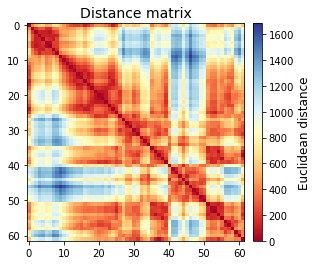

In [9]:
D = pdist(H_multW.T, 'euclidean')

fig,ax = plt.subplots(1,1)
im0 = ax.imshow(squareform(D), cmap='RdYlBu')
ax.set_title('Distance matrix', fontsize=14)

pos = ax.get_position()
cax = fig.add_axes([pos.x0+pos.width+0.02, 
                    pos.y0, 
                    0.02, 
                    pos.y0+pos.height-pos.y0])
plt.ylabel('Euclidean distance', fontsize=14)
cbar = plt.colorbar(im0, cax=cax)
cbar.ax.set_ylabel('Euclidean distance', rotation=90, fontsize=12)

plt.show()

## Dendrogram and clustering

We explore the relationship between the days (based on the activation) using a dendrogram.

In [10]:
from scipy.cluster import hierarchy

In [11]:
link = hierarchy.linkage(D, 'ward')

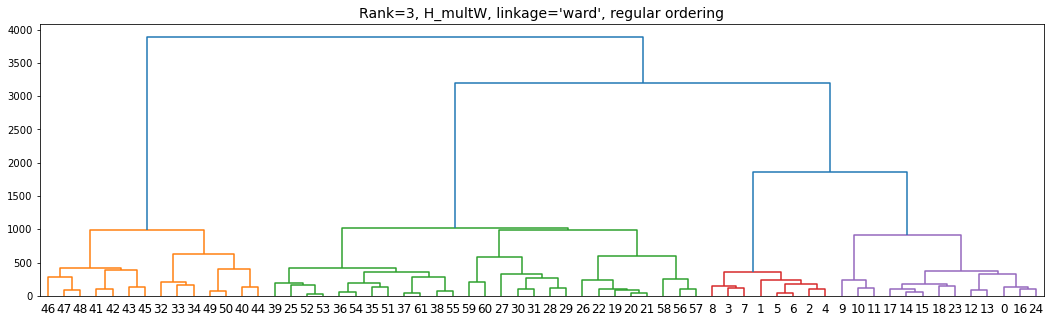

In [12]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(link, leaf_rotation=0, leaf_font_size=12, color_threshold=1500)
plt.title("Rank=3, H_multW, linkage='ward', regular ordering", fontsize=14)
plt.show()

Let's us agglomerative clustering to find the labels for each day.

In [13]:
from sklearn.cluster import AgglomerativeClustering

In [14]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = cluster.fit_predict(H_multW.T)

To visualize this we can use a simple color plot:

In [15]:
labels

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

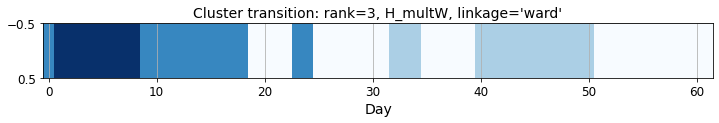

In [16]:
fig = plt.figure(figsize=(12,1))
plt.imshow(np.expand_dims(labels,axis=0), aspect='auto', cmap='Blues')
plt.yticks([-0.5, 0.5], fontsize=12)
plt.xticks(np.arange(0, 62, 10), fontsize=12)
plt.grid()
plt.xlabel('Day', fontsize=14)
plt.title("Cluster transition: rank=3, H_multW, linkage='ward'", fontsize=14)
plt.show()

## ADCP data

Here we load ADCP data resampled at 12H intervals.

In [17]:
adcp_file = './data/ADCP_resample_12H.nc'
ds_mf_resample_12H = xr.open_dataset(adcp_file)

In [18]:
def get_vmax(ds):
    lim_east = float("%2.2f" % np.nanpercentile(
        ds['eastward_seawater_velocity'], 93))
    lim_north = float("%2.2f" % np.nanpercentile(
        ds['northward_seawater_velocity'], 93))
    lim_up = float("%2.2f" % np.nanpercentile(
        ds['upward_seawater_velocity'], 93))
    return max([lim_east, lim_north, lim_up])

In [19]:
def get_v_cuttime(ds):
    vel = dict()
    vel['northsouth'] = ds['northward_seawater_velocity'].\
        sel(time=slice('2015-08-17','2015-10-17')).\
        isel(bin=slice(0,67)).compute()
    vel['eastwest'] = ds['eastward_seawater_velocity'].\
        sel(time=slice('2015-08-17','2015-10-17')).\
        isel(bin=slice(0,67)).compute()
    vel['updown'] = ds['upward_seawater_velocity'].\
        sel(time=slice('2015-08-17','2015-10-17')).\
        isel(bin=slice(0,67)).compute()
    
    depth = ds.bin_depths.isel(time=0, bin=slice(0,67)).values
    for vdir in ['northsouth', 'eastwest', 'updown']:
        vel[vdir] = vel[vdir].assign_coords(bin=depth)
        vel[vdir] = vel[vdir].rename({'bin': 'depth'})

    return vel

In [20]:
# Colorbar min max
u_v_w_12H = get_vmax(ds_mf_resample_12H)

In [21]:
# Velocities
vel_12H = get_v_cuttime(ds_mf_resample_12H)

### Velocity profile at 12H resampling interval

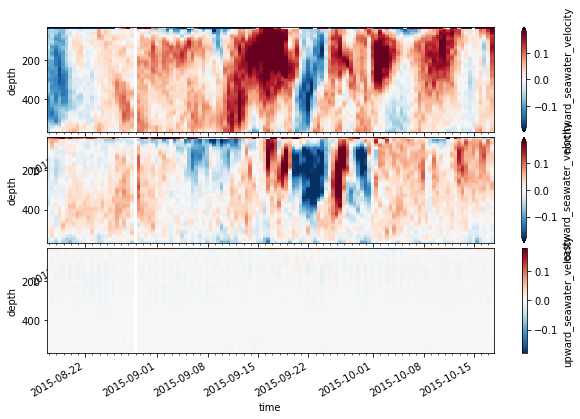

In [22]:
fig, ax = plt.subplots(3,1,figsize=(10,6))
plt.subplots_adjust(hspace=0.05)
for seq,vdir in enumerate(['northsouth', 'eastwest', 'updown']):
    vel_12H[vdir].plot(x='time', ax=ax[seq], vmin=-u_v_w_12H, vmax=u_v_w_12H, cmap='RdBu_r', yincrease=False)
    ax[seq].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
plt.show()

## Figure 5: putting everything together

Plot the distance matrix, clusters, and ADCP observation all in one figure.

The goal of this figure is to show the visual correlation between current velocity changes with echogram pattern activation changes.

In [23]:
import datetime
import matplotlib.dates as mdates
import matplotlib.colors as colors

In [24]:
# Set date locator and formatter to use with plt.plot_dates
date1 = datetime.datetime(2015, 8, 17, 0, 0, 0)
date2 = datetime.datetime(2015, 10, 17, 23, 59, 59)
locator = mdates.AutoDateLocator().get_locator(date1, date2)
formatter = mdates.AutoDateFormatter(locator)
(type(locator), type(formatter))

x_lims = mdates.date2num([date1, date2])
y_lims = mdates.date2num([date1, date2])

In [25]:
title_size = 14
panel_label_size = 14
tick_label_size = 12
ylabel_size = 14
pad_size = 0

In [26]:
def add_panel_labels():
    fig.text(x=-0.25,y=1,s='A',
             transform=ax_distance.transAxes,
             fontsize=panel_label_size, fontweight='bold', va='center')
    fig.text(x=-0.25,y=0.8,s='B',
             transform=ax_cluster.transAxes,
             fontsize=panel_label_size, fontweight='bold', va='center')
    fig.text(x=-0.25,y=1,s='C',
             transform=ax_nv.transAxes,
             fontsize=panel_label_size, fontweight='bold', va='center')

In [27]:
def plot_distance_mtx_on_ax(ax, D_mtx, colormap='RdYlBu'):
    im = ax.imshow(D_mtx, cmap=colormap, aspect='auto',    #RdYlBu
              extent = [x_lims[0], x_lims[1],  y_lims[1], y_lims[0]])
    ax.xaxis_date()
    ax.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    ax.yaxis_date()
    ax.yaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax.yaxis.set_minor_locator(mdates.AutoDateLocator())
    ax.set_aspect('equal', 'box')
    plt.setp(ax.get_xticklabels(), rotation=20, 
             fontsize=tick_label_size, horizontalalignment='right')
    plt.setp(ax.get_yticklabels(), rotation=20, 
             fontsize=tick_label_size, horizontalalignment='right')
    ax.tick_params(axis='both', which='major', pad=pad_size)
    ax.tick_params(labelsize=tick_label_size) 
    return im

In [28]:
def plot_cluster_transition(ax, colormap='YlGnBu'):
    cmap_cluster = plt.cm.get_cmap(colormap)
    boundaries = np.arange(5)
    norm = colors.BoundaryNorm(boundaries, cmap_cluster.N, clip=True)
    im = ax.imshow(np.expand_dims(labels, axis=0), cmap=cmap_cluster, 
                   norm=norm, aspect='auto', interpolation=None,
                   extent = [x_lims[0], x_lims[1],  -0.5, 0.5])
    ax.xaxis_date()
    ax.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='both', which='major', pad=pad_size)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_title('Clusters', fontsize=title_size)

In [29]:
def plot_ADCP_currents(colormap='RdBu_r'):
    # ADCP N-S
    im = vel_12H['northsouth'].plot(x='time',ax=ax_nv,
            vmin=-0.25, vmax=0.2, 
            cmap=colormap, add_colorbar=False, yincrease=False)
    ax_nv.annotate('North', 
                   xy=(0.75,0.16), xycoords='axes fraction', 
                   fontsize=ylabel_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=0.0))

    # ADCP E-W
    im = vel_12H['eastwest'].plot(x='time',ax=ax_ev,
            vmin=-0.2, vmax=0.2, 
            cmap=colormap, add_colorbar=False, yincrease=False)  #RdBu_r
    ax_ev.annotate('East', 
                   xy=(0.78,0.16), xycoords='axes fraction', 
                   fontsize=ylabel_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=0.0))

    # ADCP y-axis label
    fig.text(x=-0.25,y=0,s='Depth (m)',
             transform=ax_nv.transAxes,
             fontsize=ylabel_size, rotation=90, va='center')

    # Adjust axis labels
    ax_ev.xaxis_date()
    ax_ev.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    ax_ev.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax_ev.xaxis.set_minor_locator(mdates.AutoDateLocator())
    ax_ev.tick_params(axis='x', which='major', length=5, pad=pad_size)
    ax_ev.tick_params(axis='x', which='minor', length=4)
    ax_ev.tick_params(axis='y', which='major', length=4, pad=pad_size)
    ax_nv.set_xticklabels('')
    ax_nv.tick_params(axis='x', which='both', length=0, pad=pad_size)
    ax_nv.tick_params(axis='y', which='major', length=4, pad=pad_size)
    plt.setp(ax_ev.get_xticklabels(), fontsize=tick_label_size)
    plt.setp(ax_nv.get_yticklabels(), fontsize=tick_label_size)
    plt.setp(ax_ev.get_yticklabels(), fontsize=tick_label_size)
    
    # Current axes location
    pos_nv = ax_nv.get_position()
    pos_ev = ax_ev.get_position()
    ax_nv.set_position([pos_nv.x0, pos_nv.y0-0.02, pos_nv.width, pos_nv.height+0.005])
    ax_ev.set_position([pos_ev.x0, pos_ev.y0-0.025, pos_ev.width, pos_ev.height+0.005])
    
    # ADCP colorbar
    pos_nv = ax_nv.get_position()
    pos_ev = ax_ev.get_position()
    cbar_ax = fig.add_axes([pos_nv.x0+pos_nv.width+0.03, 
                            pos_ev.y0, 
                            0.03, pos_nv.y0+pos_nv.height-pos_ev.y0])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cbar_ax)
    cbar.set_ticks(np.arange(-0.2, 0.25, 0.1))
    cbar.ax.tick_params(labelsize=tick_label_size) 
    cbar.ax.set_ylabel('Velocity (m/s)', rotation=90, fontsize=ylabel_size)

    ax_nv.set_title('Ocean currents', fontsize=title_size, pad=14)
    plt.setp(ax_nv.get_xticklabels(), visible=False)
    ax_nv.set_xlabel('')
    ax_ev.set_xlabel('Time', fontsize=ylabel_size)
    ax_nv.set_ylabel('')
    ax_ev.set_ylabel('')

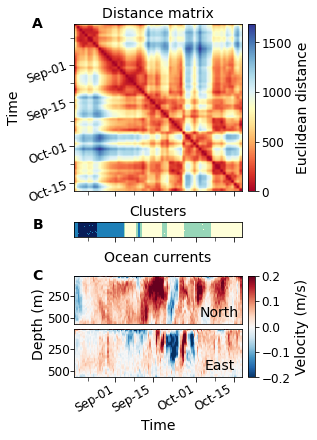

In [30]:
fig = plt.figure(figsize=(3,6))

gs = fig.add_gridspec(13, 1)
ax_distance = fig.add_subplot(gs[:6, 0])
ax_cluster = fig.add_subplot(gs[7:8, 0])
ax_nv = fig.add_subplot(gs[9:11, 0])
ax_ev = fig.add_subplot(gs[11:, 0])

# Add panel labels
add_panel_labels()


# Plot distance matrix
im_d_mtx = plot_distance_mtx_on_ax(ax_distance, squareform(D), colormap='RdYlBu')
ax_distance.set_title('Distance matrix', fontsize=title_size)
plt.setp(ax_distance.get_xticklabels(), visible=False)
ax_distance.set_ylabel('Time', fontsize=ylabel_size)

# Plot ADCP currents
plot_ADCP_currents(colormap='RdBu_r')

# Plot cluster transition
plot_cluster_transition(ax_cluster)

# Adjust cluster axis
pos_nv= ax_nv.get_position()
pos_cluster = ax_cluster.get_position()
ax_cluster.set_position([pos_cluster.x0, pos_nv.y0+pos_nv.height+0.09, 
                         pos_cluster.width, pos_cluster.height*0.7])
ax_cluster.tick_params(axis='both', which='major', length=5)
ax_cluster.tick_params(axis='both', which='minor', length=4)
ax_cluster.set_xticklabels('')

# Adjust distance matrix axis
pos_d_mtx = ax_distance.get_position()
ax_distance.set_position([pos_cluster.x0, pos_d_mtx.y0-0.2, 
                          pos_cluster.width, pos_cluster.width])   # [left, bottom, width, height]
ax_distance.tick_params(axis='both', which='major', length=5)
ax_distance.tick_params(axis='both', which='minor', length=4)

# Plot distance matrix colorbar
pos_d_mtx = ax_distance.get_position()
cbar_ax = fig.add_axes([pos_d_mtx.x0+pos_d_mtx.width+0.03, 
                        pos_d_mtx.y0, 
                        0.03, pos_d_mtx.height])  # [left, bottom, width, height]
cbar = plt.colorbar(im_d_mtx, cax=cbar_ax)
cbar.ax.tick_params(labelsize=tick_label_size) 
cbar.ax.set_ylabel('Euclidean distance', rotation=90, fontsize=ylabel_size)

# Save figure
plt.savefig('./figs/fig_distance.png', 
            dpi=150, bbox_inches = 'tight', pad_inches = 0.01)
plt.show()